# Click Throughs
Will they click our ad?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use classification models to make click-through predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from importlib import reload


#import my personal modules created for this report
import wrangle as w
#import explore as e
#import model as m

## Acquire

* Data acquired from interviewquery github on December 12, 2022.
* It contained 600000 rows and 24 columns
* Each observation represents an instance of an online advertisement
* Each column represents a feature of those visits

In [2]:
#import train and test data sets from interviewquery github
unclean_click_through_data = w.acquire_click_through_data()

## Prepare
* Checked for nulls, there were none
* Changed the ```hour``` column to datetime
* Split data into train, validate, and test (65/20/15)

In [3]:
#prep data
click_through_data = w.prep_data(unclean_click_through_data)

In [6]:
#split data
train, validate, test = w.split_data(click_through_data)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**id**| | *int*|
| **hour** | The date and hour of day |*datetime*|
| **C1** | Anonymized categorical variable |*int*|
|**banner_pos**| Location of ad on the page | *int*|
|**site_id**| Id of the site where the ad was displayed | *str*|
|**site_domain**| | *str*|
|**site_category**| | *str*|
|**app_id**| Square footage of the land where the property is located | *float*|
|**app_domain**| | *float*|
|**deck**| | *float*|
|**pool**| | *float*|
|**garage**| | *float*|
|**hottub**| | *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [7]:
#show the first few rows of the train data
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week,working_hours
366134,2009636145773373157,0,2014-10-27 16:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,16,Monday,True
95054,17172250707259950008,0,2014-10-24 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,2502,0,39,-1,221,6,Friday,False
189299,2922056073063093914,0,2014-10-25 13:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,320,50,1722,0,35,100083,79,13,Saturday,True
569650,4743847194723927815,0,2014-10-29 14:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,320,50,2728,0,290,-1,42,14,Wednesday,True
581283,218700043766238420,1,2014-10-29 17:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,320,50,1993,2,1063,100084,33,17,Wednesday,True


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389999 entries, 366134 to 151297
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                389999 non-null  uint64        
 1   click             389999 non-null  int64         
 2   hour              389999 non-null  datetime64[ns]
 3   C1                389999 non-null  int64         
 4   banner_pos        389999 non-null  int64         
 5   site_id           389999 non-null  object        
 6   site_domain       389999 non-null  object        
 7   site_category     389999 non-null  object        
 8   app_id            389999 non-null  object        
 9   app_domain        389999 non-null  object        
 10  app_category      389999 non-null  object        
 11  device_id         389999 non-null  object        
 12  device_ip         389999 non-null  object        
 13  device_model      389999 non-null  object        
 14 

## Explore

### 1. What percentage of visits resulted in a click-through?

<AxesSubplot:xlabel='click', ylabel='count'>

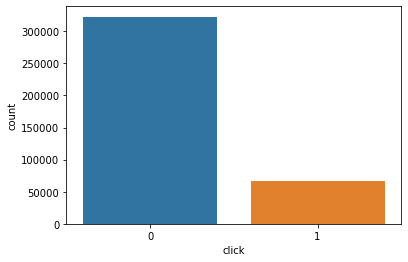

In [8]:
sns.countplot(data=train, x='click')

### 2. Does the hour of the day have an impact of click-throughs?

In [9]:
# plotting defaults
plt.rc('figure', figsize=(20, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

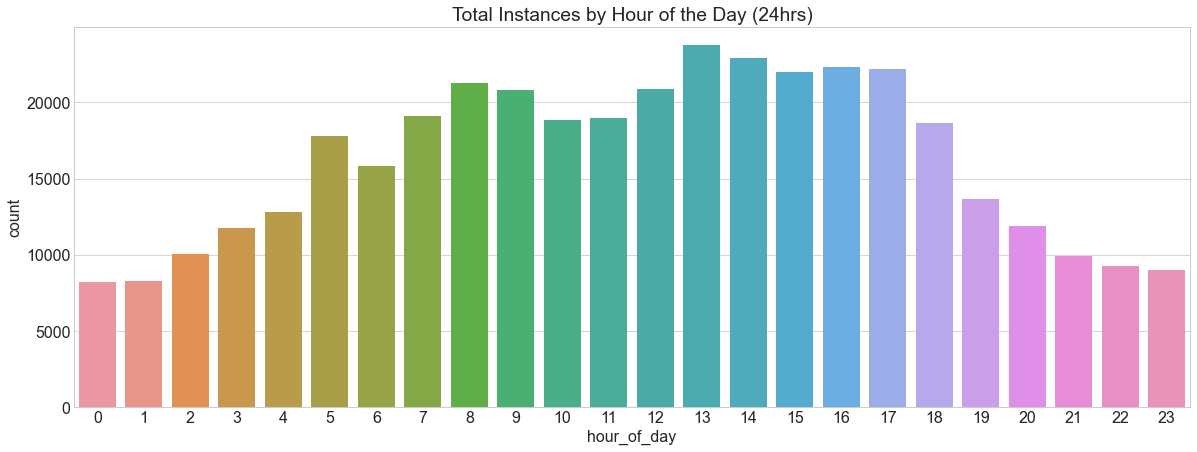

In [34]:
sns.countplot(data=train, x='hour_of_day')
plt.title("Total Instances by Hour of the Day (24hrs)")
plt.show()

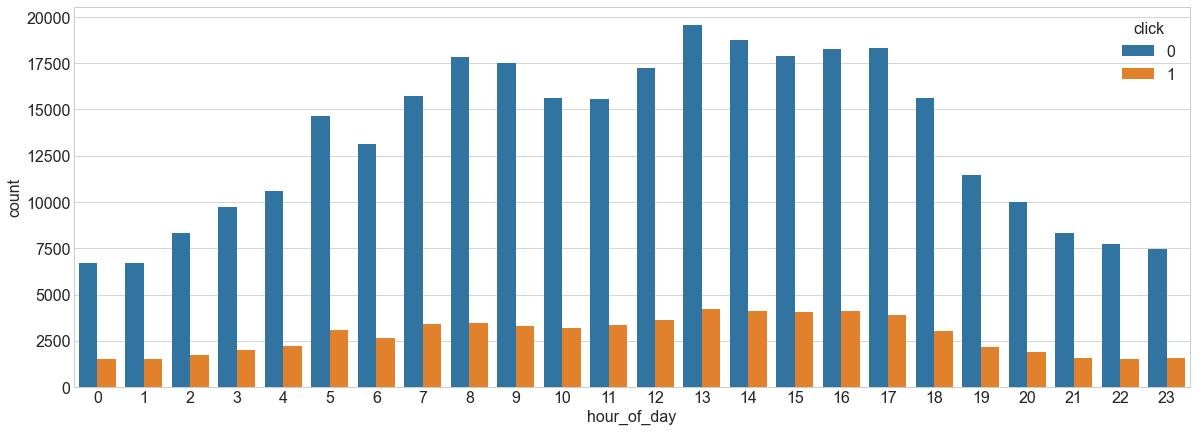

In [17]:
sns.countplot(data=train, x='hour_of_day', hue='click');

<AxesSubplot:xlabel='hour_of_day'>

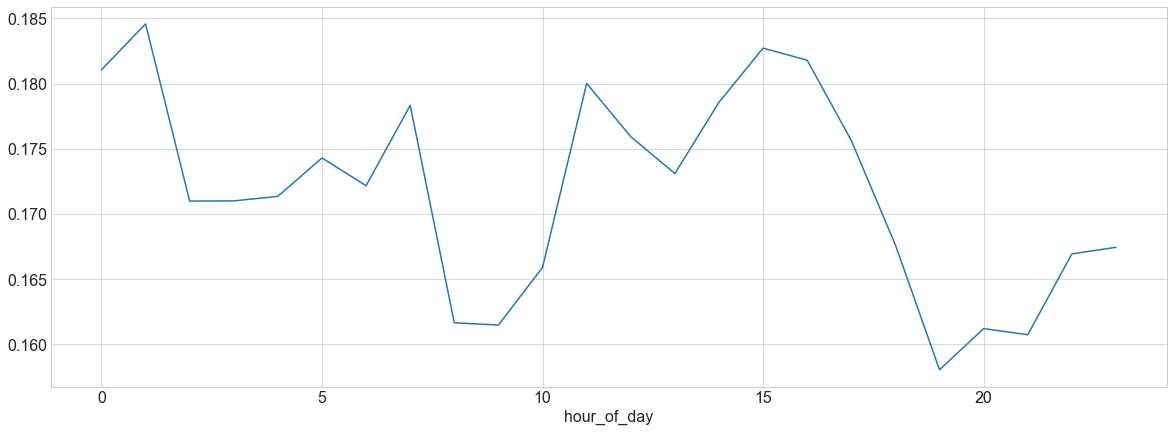

In [17]:
train.groupby('hour_of_day').click.mean().plot();

**It looks like there are more click throughs per instance at 1 am.** 

***Let's do a $chi^2$ to see if there is a relationship***

**Set Hypothesis**

$H_0$ = There is no relationship between ```hour_of_day``` and ```click```.

$H_a$ = There is a relationship between ```hour_of_day``` and ```click```.

In [46]:
#create crosstab of the two variables 
observed = pd.crosstab(train["hour_of_day"], train["click"])

#run χ^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"χ^2: {chi2:.6}\np-value: {p:.6}")

χ^2: 176.366
p-value: 1.28199e-25


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```hour_of_day``` and ```click```.** 

## 3. Does the day of the week have an impact of click-throughs?

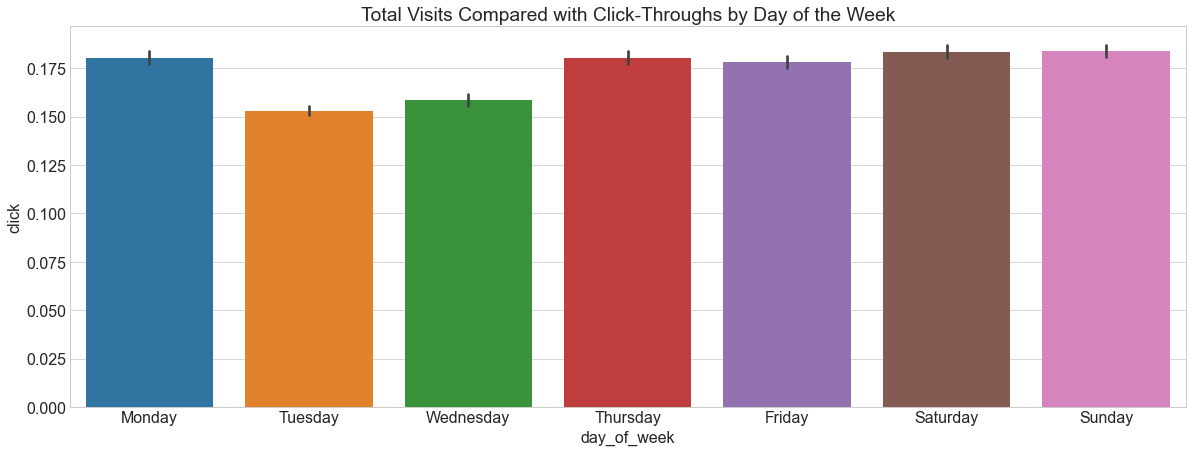

In [43]:
sns.barplot(data=train, x='day_of_week', y='click',order=days)
plt.title("Total Visits Compared with Click-Throughs by Day of the Week")
plt.show()

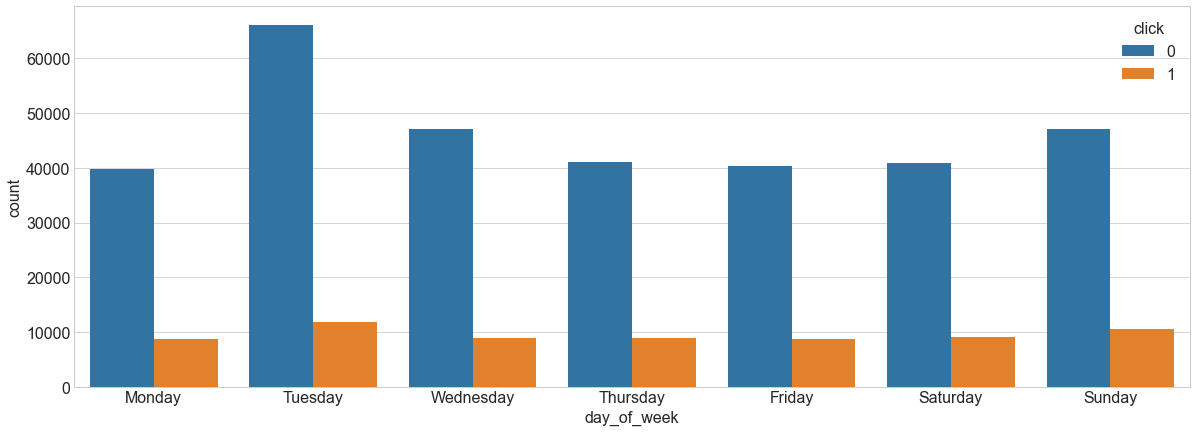

In [24]:
sns.countplot(data=train, x='day_of_week', hue='click', order=days);

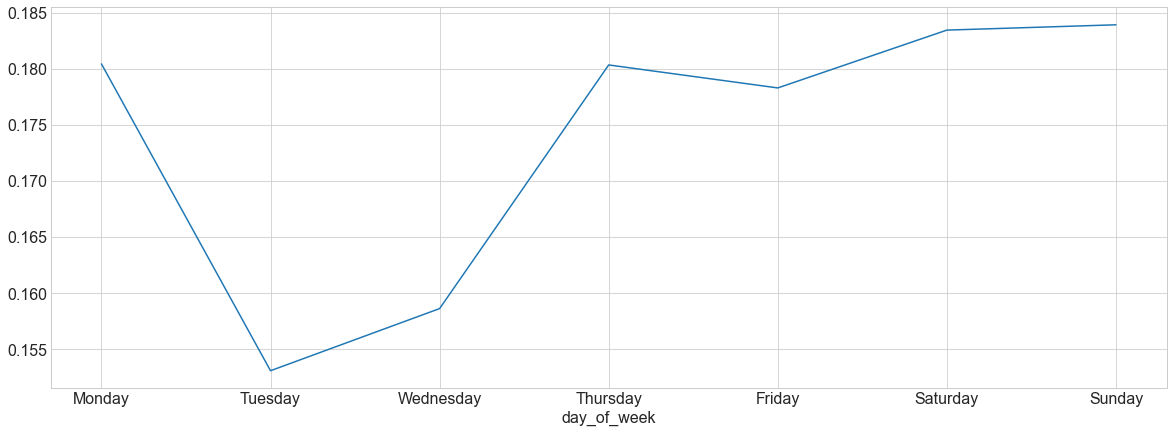

In [23]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
train.groupby('day_of_week').click.mean().reindex(days).plot();

**Set Hypothesis**

$H_0$ = There is no relationship between ```day_of_week``` and ```click```.

$H_a$ = There is a relationship between ```day_of_week``` and ```click```.

In [36]:
#create crosstab of the two variables 
observed = pd.crosstab(train["day_of_week"], train["click"])

#run χ^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"χ^2: {chi2:.6}\np-value: {p:.6}")

χ^2: 431.902
p-value: 3.84995e-90


In [60]:
for day in days:
    observed = pd.crosstab(train["day_of_week"]==day, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f"{day} results: χ^2: {chi2:.6}\np-value: {p:.6}")

Monday results: χ^2: 24.8197
p-value: 6.29506e-07
Tuesday results: χ^2: 256.61
p-value: 9.40733e-58
Wednesday results: χ^2: 87.5769
p-value: 8.1065e-21
Thursday results: χ^2: 25.0873
p-value: 5.47915e-07
Friday results: χ^2: 13.4598
p-value: 0.000243728
Saturday results: χ^2: 48.8018
p-value: 2.83173e-12
Sunday results: χ^2: 62.5405
p-value: 2.61018e-15


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```day_of_week``` and ```click```.** 

## 4. Does banner position impact click through?

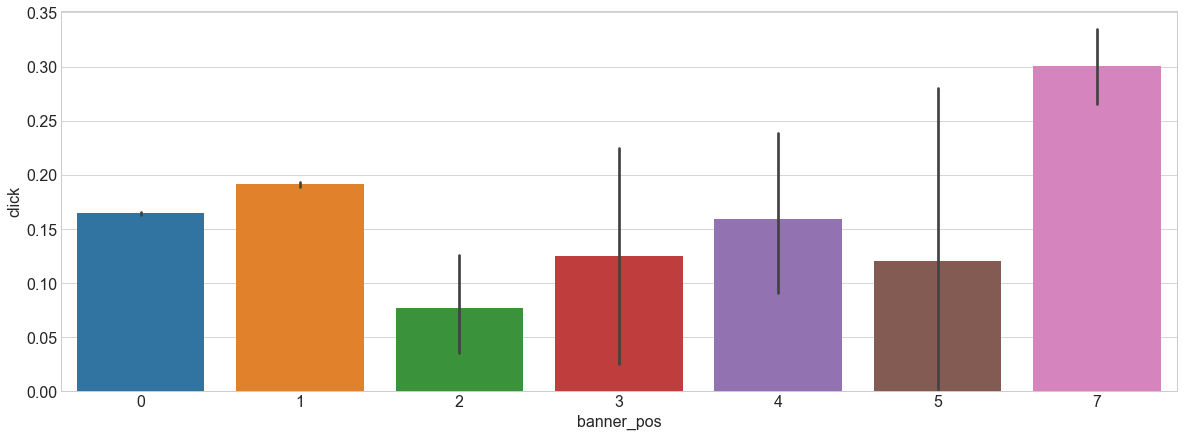

In [47]:
sns.barplot(data=train, x='banner_pos', y='click');

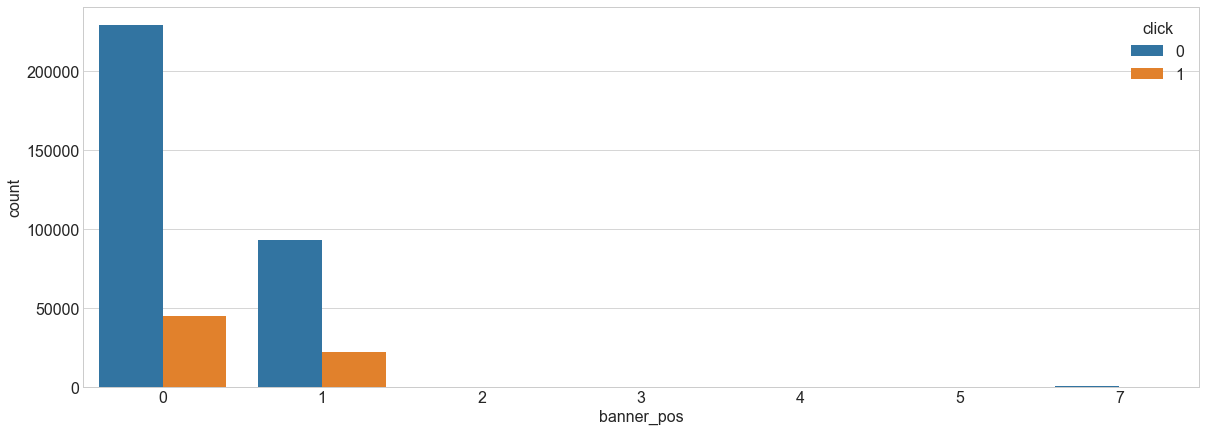

In [48]:
sns.countplot(data=train, x='banner_pos', hue='click');

**Set Hypothesis**

$H_0$ = There is no association between ```banner_pos``` and ```click```.

$H_a$ = There is a association between ```banner_pos``` and ```click```.

In [58]:
for i in train['banner_pos'].unique():
    observed = pd.crosstab(train["banner_pos"]==i, train["click"])
    #run χ^2 test
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f"banner_pos {i} results: χ^2: {chi2:.6}\np-value: {p:.6}")

banner_pos 0 results: χ^2: 419.231
p-value: 3.58723e-93
banner_pos 1 results: χ^2: 397.382
p-value: 2.04537e-88
banner_pos 7 results: χ^2: 72.1174
p-value: 2.02772e-17
banner_pos 4 results: χ^2: 0.0361544
p-value: 0.849197
banner_pos 3 results: χ^2: 0.342021
p-value: 0.558665
banner_pos 2 results: χ^2: 8.48676
p-value: 0.00357741
banner_pos 5 results: χ^2: 0.184251
p-value: 0.667745


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```banner_pos``` and ```click```.** 

## 5. Does

### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**size_location_cluster**| |
|**bath_bed_ratio**| From our Spearman's test we saw that the correlation coefficient is 0.32 between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Spearman's test we saw that the correlation coefficient is 0.27 between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [15]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'logerror', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [18]:
import sklearn.metrics as metric

def baseline_models(y_train, y_validate):
    '''
    Takes in y_train and y_validate and returns a df of 
    baseline_mean and baseline_median and how they perform
    '''
    train_predictions = pd.DataFrame(y_train)
    validate_predictions = pd.DataFrame(y_validate)
    
    y_pred_mean = y_train.mean()
    train_predictions['y_pred_mean'] = y_pred_mean
    validate_predictions['y_pred_mean'] = y_pred_mean
    
    y_pred_median = y_train.median()
    train_predictions['y_pred_median'] = y_pred_median
    validate_predictions['y_pred_median'] = y_pred_median

    # create the metric_df as a blank dataframe
    metric_df = pd.DataFrame(data=[
    {
        'model': 'mean_baseline', 
        'RMSE_train': metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5,
        'RMSE_validate': metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5,
        'Difference': (( metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5)-(metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5))
    }])

    return metric_df.append(
            {
                'model': 'median_baseline', 
                'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5,
                'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5,
                'Difference': (( metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5)-(metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5))
            }, ignore_index=True)

In [19]:
baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,0.174556,0.18238,-0.007824
1,median_baseline,0.174886,0.18275,-0.007864


### Model Comparison

In [ ]:
#run and compare models
#m.regression_models(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 